<a href="https://www.kaggle.com/code/najeebz/titanic-aggregated-models-8-features-0-79-score?scriptVersionId=161101264" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Creator:
### Najeeb Zaidi
### Github: https://github.com/snajeebz
### zaidi.nh@gmail.com
### Contributors: 
1. https://github.com/snajeebz
## Dataset Source: 
1. https://www.kaggle.com/competitions/titanic

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import os
import seaborn as sns
#Disable warning
import warnings
warnings.filterwarnings("ignore")



# Importing the Dataset

In [2]:
try:   #for Local Environment
    train_df = pd.read_csv("Dataset/train.csv")
    serving_df = pd.read_csv("Dataset/test.csv")
except: #for Kaggle Environment
    train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
    serving_df = pd.read_csv("/kaggle/input/titanic/test.csv")

train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## 1. Dataset EDA

In [3]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Observations:
1. Cabin has got 687 nulls which is more than 75% of the rows. So I guess it will be better to not use cabin as a feature for our model.
2. Age has around 20% nulls. So we will try the best to fill them up.

## Let's dig deep into Age

In [4]:
print("Group by Parch: \n",train_df['Age'].isna().groupby(train_df['Parch']).value_counts())
print("Group by SibSp: \n",train_df['Age'].isna().groupby(train_df['SibSp']).value_counts())
print("Group by Pclass: \n",train_df['Age'].isna().groupby(train_df['Pclass']).value_counts())



Group by Parch: 
 Parch  Age  
0      False    521
       True     157
1      False    110
       True       8
2      False     68
       True      12
3      False      5
4      False      4
5      False      5
6      False      1
Name: count, dtype: int64
Group by SibSp: 
 SibSp  Age  
0      False    471
       True     137
1      False    183
       True      26
2      False     25
       True       3
3      False     12
       True       4
4      False     18
5      False      5
8      True       7
Name: count, dtype: int64
Group by Pclass: 
 Pclass  Age  
1       False    186
        True      30
2       False    173
        True      11
3       False    355
        True     136
Name: count, dtype: int64


## Observation
1. Out the Nans of age 16% are female.
2. Out the Nans of age 21% are male.

# Let's impute the nulls.

### You can refer to the [Imputating the Nans by ML](https://www.kaggle.com/code/najeebz/titanic-deep-learning) results on that notebook:
> It resulted in 80% Accurate Results.

In [5]:
def impute_age(data):
    fill=data['Age'][data['Age'].isnull()==False].median()
    data['Age'].fillna(fill, inplace=True)
    return data
train_df = impute_age(train_df)
serving_df=impute_age(serving_df)
print('After Imputations:\n ', train_df.isnull().sum())
fill=serving_df['Fare'][serving_df['Fare'].isnull()==False].median()
serving_df['Fare'].fillna(fill, inplace=True)


After Imputations:
  PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


# Features Functions

## Travelling alone or with family?

In [6]:
def alone(train_df):
    train_df['Is_alone']=(train_df.SibSp + train_df.Parch) < 1
    return train_df

## Embarked Pre Processing

In [7]:
def embarked(train_df):
    #Filling the NAN
    train_df['Embarked']=train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
    train_df['Embarked']=pd.to_numeric(train_df['Embarked'].replace(['S','C','Q'],[0,1,2]))
    return train_df
serving_df=embarked(serving_df)
train_df=embarked(train_df)

## Cabin Assigned or not?

In [8]:
def cabin_assigned(data):
    data['is_cabin']=(data['Cabin'].isnull()==False)
    return data


## Number of accompanying family members 

In [9]:
def family_size(data):
    data['Family']=data.SibSp+data.Parch+1
    return data


## Is minor (age<=18)

In [10]:
train_df['minor']=(train_df.Age<=18)
serving_df['minor']=(serving_df.Age<=18)

# Visualizations

<Axes: xlabel='Survived', ylabel='Sex'>

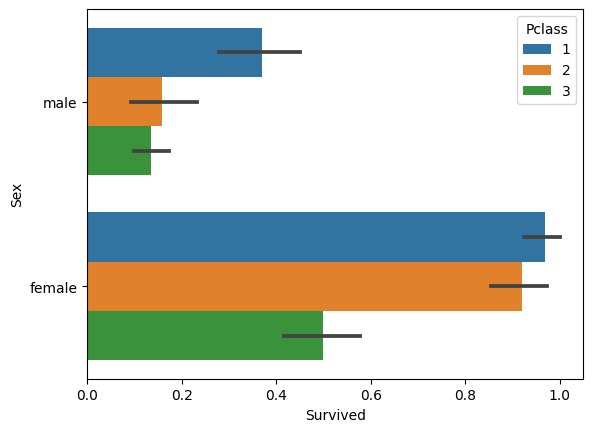

In [11]:
sns.barplot(data=train_df,x='Survived',y='Sex', hue='Pclass')

<Axes: xlabel='Survived', ylabel='Sex'>

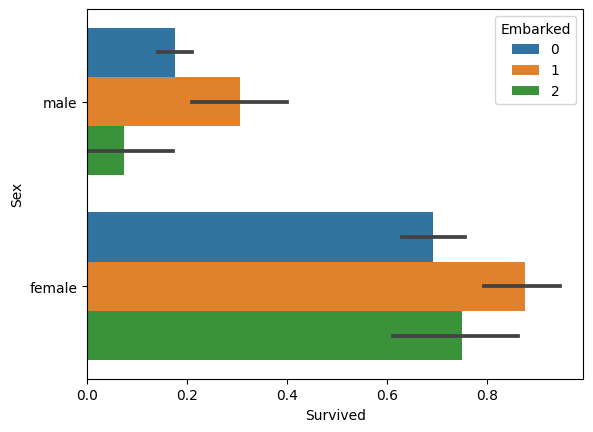

In [12]:
sns.barplot(data=train_df,x='Survived',y='Sex', hue='Embarked')

<Axes: xlabel='Survived', ylabel='Age'>

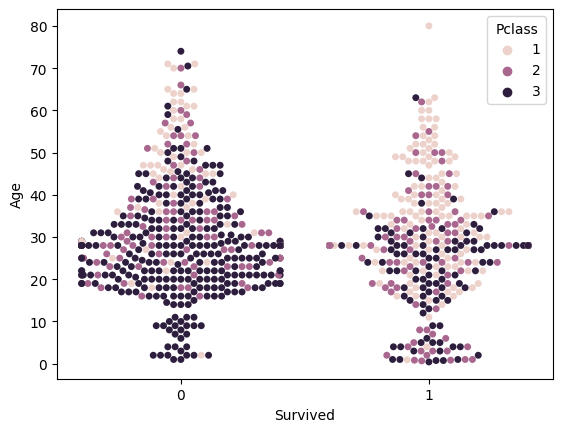

In [13]:
sns.swarmplot(data=train_df,x='Survived',y='Age', hue='Pclass')

<Axes: xlabel='Survived', ylabel='Age'>

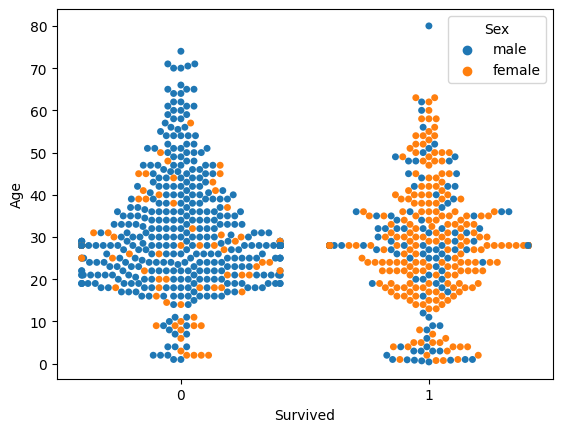

In [14]:
sns.swarmplot(data=train_df,x='Survived',y='Age', hue='Sex')

Upper Outliers: Series([], Name: Age, dtype: float64)
Lower Outliers: Series([], Name: Age, dtype: float64)


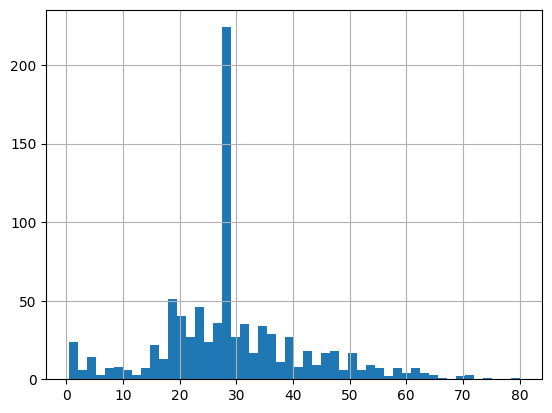

In [15]:
train_df['Age'].hist(bins=50)
print('Upper Outliers:',train_df['Age'][train_df['Age']>80])
print('Lower Outliers:',train_df['Age'][train_df['Age']<0])

In [16]:
import plotly.express as px
fig = px.sunburst(
    train_df,
    path=['Embarked','Sex','Pclass','Survived'], 
    color='Survived',color_discrete_map={'1':'gold', '0':'darkblue'},
    width=1200, height=1200
)
fig.show()

# Pre Processing

In [17]:
train_df=pd.get_dummies(train_df, columns=['Sex'])
serving_df=pd.get_dummies(serving_df, columns=['Sex'])


# Features Generation

In [18]:
train_df=alone(train_df)
serving_df=alone(serving_df)
train_df=embarked(train_df)
serving_df=embarked(serving_df)
train_df=cabin_assigned(train_df)
serving_df=cabin_assigned(serving_df)
train_df=family_size(train_df)
serving_df=family_size(serving_df)
serving_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'minor', 'Sex_female', 'Sex_male',
       'Is_alone', 'is_cabin', 'Family'],
      dtype='object')

## Features via Clustering

In [19]:
def cluster(X):
    from sklearn import cluster
    agglo = cluster.KMeans(n_clusters=5,random_state=0, n_init="auto")
    agglo.fit(X)
    return ((agglo.labels_+1)/5)
X=train_df[['SibSp', 'Parch','Fare','Sex_female', 'Sex_male','Pclass']]
train_df['Clusters-1']=cluster(X) 
X=train_df[['Age']]
train_df['agebin']=cluster(X) 
X=train_df[['Fare']]
train_df['farebin']=cluster(X)
X=train_df[['Sex_female', 'Sex_male','Pclass']]
train_df['Clusters-4']=cluster(X)
X=train_df[['Fare', 'Is_alone','Pclass']]
train_df['Clusters-5']=cluster(X)
train_df


X=serving_df[['SibSp', 'Parch','Fare','Sex_female', 'Sex_male','Pclass']]
serving_df['Clusters-1']=cluster(X) 
X=serving_df[['Age']]
serving_df['agebin']=cluster(X) 
X=serving_df[['Fare']]
serving_df['farebin']=cluster(X)
X=serving_df[['Sex_female', 'Sex_male','Pclass']]
serving_df['Clusters-4']=cluster(X)
X=serving_df[['Fare', 'Is_alone','Pclass']]
serving_df['Clusters-5']=cluster(X)


In [20]:
df = train_df[['Age','Family','minor','is_cabin','SibSp', 'Embarked', 'Is_alone','Parch', 'Fare','PassengerId', 'Sex_female', 'Sex_male','Survived','Pclass','Clusters-1','agebin','farebin','Clusters-4','Clusters-5']]
figure= px.imshow(df.corr(), text_auto=True, width=1200, height=1200)
figure.show()
test_df = serving_df[['Age','Family','minor','is_cabin','SibSp', 'Embarked', 'Is_alone','Parch', 'Fare','PassengerId', 'Sex_female', 'Sex_male','Pclass','Clusters-1','agebin','farebin','Clusters-4','Clusters-5']]


### Clusters added a feature with 15% correlation.

# Preparing Training Dataset

In [21]:
X=df.drop(columns='Survived')
y=df[['Survived']]

In [22]:
def scale(X):
    from sklearn import preprocessing
    scaled=preprocessing.StandardScaler()
    scaler=scaled.fit(X)
    X=scaler.transform(X)
    return X

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(scale(X),y,train_size=0.8, random_state=42)

In [24]:
df

,Age,Family,minor,is_cabin,SibSp,Embarked,Is_alone,Parch,Fare,PassengerId,Sex_female,Sex_male,Survived,Pclass,Clusters-1,agebin,farebin,Clusters-4,Clusters-5
0,22.0,2,False,False,1,0,False,0,7.2500,1,False,True,0,3,0.6,0.4,0.6,0.4,0.6
1,38.0,2,False,True,1,1,False,0,71.2833,2,True,False,1,1,0.2,0.8,0.2,0.6,0.2
2,26.0,1,False,False,0,0,True,0,7.9250,3,True,False,1,3,0.6,0.6,0.6,0.8,0.6
3,35.0,2,False,True,1,0,False,0,53.1000,4,True,False,1,1,0.2,0.6,0.2,0.6,0.2
4,35.0,1,False,False,0,0,True,0,8.0500,5,False,True,0,3,0.6,0.6,0.6,0.4,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,1,False,False,0,0,True,0,13.0000,887,False,True,0,2,0.6,0.6,0.6,0.2,0.6
887,19.0,1,False,True,0,0,True,0,30.0000,888,True,False,1,1,0.6,0.4,0.6,0.6,0.6
888,28.0,4,False,False,1,0,False,2,23.4500,889,True,False,0,3,0.6,0.6,0.6,0.8,0.6
889,26.0,1,False,True,0,1,True,0,30.0000,890,False,True,1,1,0.6,0.6,0.6,1.0,0.6


# Evaluation of the Training Model

In [25]:
def evaluate(y_test,ypred):
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    print("Accuracy: ",accuracy_score(y_test,y_pred)) 
    cm = confusion_matrix(y_test, y_pred)
    figure= px.imshow(cm,text_auto=True, width=1200, height=1200)
    figure.show()

In [26]:
np.ravel(y_train)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,

# Hyper Parameter Tuning

In [27]:
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
result=pd.DataFrame(columns=['PassengerId', 'KNN','RF','MLP','ABC','GBC', 'Agg','Survived'])
import xgboost as xgb
from tqdm import tqdm
w=pd.DataFrame(columns=['mod','weight'])
result['PassengerId']=test_df['PassengerId']
models = {
    'KNN': KNeighborsClassifier(),
    'RF' : RandomForestClassifier(),
    'MLP': MLPClassifier(),
    'ABC': AdaBoostClassifier(),
    'GBC': GradientBoostingClassifier(validation_fraction=0.1, n_iter_no_change=15)
    
}
#'ccp_alpha': 0.1, 'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'exponential', 'min_impurity_decrease': 0.1, 'n_estimators': 20, 'subsample': 1}
grid_param={
'GBC':  {
        'loss':['log_loss', 'exponential'],
        'criterion': ['friedman_mse', 'squared_error'],
        'n_estimators': [5000,100, 60],
        'learning_rate': [0.01,0.04,0.06],
        'min_impurity_decrease':[0.1],
        'ccp_alpha':10.0 ** -np.arange(4,10,1),
        'subsample': [1.5, 1, 2]
        },
'ABC':  {
        'n_estimators':[5000, 1000],
        'learning_rate':[0.02,0.01, 0.001]
        },
'KNN': {
        'n_neighbors':range(1,10,1)
       },
'MLP': {
        'solver':['lbfgs', 'sgd', 'adam' ],
        'max_iter':[1000], 
        'activation':['relu','tanh','identity'],
        'learning_rate':['adaptive'], 
        'early_stopping':[1],
        'alpha':10.0 ** -np.arange(4,10,1),
        'n_iter_no_change':[10]
       },
'RF':  {
       'criterion':['gini', 'entropy', 'log_loss'],
       'max_features':['sqrt', 'log2', 'None']
    }
          }

for name,mod in tqdm(models.items()):
   gs = GridSearchCV(estimator=mod, param_grid=grid_param[name], cv=3, scoring='accuracy')
   gs.fit(X_train,np.ravel(y_train))
   print('Model: ', name, ' Accuracy:',format(gs.best_score_,".2f"),  ' Best Parameters:',gs.best_params_)
   y_pred=gs.predict(scale(test_df))
   #evaluate(y_test,y_pred)
   w.loc[len(w)]=[name,gs.best_score_]
   result[name]=gs.predict_proba(scale(test_df))[:,1]
  # except:
   # result[name]=gs.predict_proba(scale(test_df))[:,1]
   

 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

Model:  KNN  Accuracy: 0.80  Best Parameters: {'n_neighbors': 8}


 40%|████      | 2/5 [00:06<00:11,  3.68s/it]

Model:  RF  Accuracy: 0.82  Best Parameters: {'criterion': 'log_loss', 'max_features': 'sqrt'}


 60%|██████    | 3/5 [02:17<02:03, 61.73s/it]

Model:  MLP  Accuracy: 0.81  Best Parameters: {'activation': 'identity', 'alpha': 0.0001, 'early_stopping': 1, 'learning_rate': 'adaptive', 'max_iter': 1000, 'n_iter_no_change': 10, 'solver': 'lbfgs'}
Model:  ABC  Accuracy: 0.81  Best Parameters: {'learning_rate': 0.01, 'n_estimators': 1000}


100%|██████████| 5/5 [06:05<00:00, 73.07s/it]

Model:  GBC  Accuracy: 0.83  Best Parameters: {'ccp_alpha': 1e-05, 'criterion': 'friedman_mse', 'learning_rate': 0.06, 'loss': 'exponential', 'min_impurity_decrease': 0.1, 'n_estimators': 60, 'subsample': 1}


In [28]:
rf=w['weight'][w['mod']=='RF'].item()
knn=w['weight'][w['mod']=='KNN'].item()
abc=w['weight'][w['mod']=='ABC'].item()
gbc=w['weight'][w['mod']=='GBC'].item()
mlp=w['weight'][w['mod']=='MLP'].item()
wmx=w['weight'].max()

In [29]:
w

,mod,weight
0,KNN,0.800571
1,RF,0.820202
2,MLP,0.810398
3,ABC,0.810398
4,GBC,0.828677


In [30]:
wmx

0.8286766183266555

# Prediction and Submission

## Prediction Data

In [31]:

result['Agg']=((result.RF*rf)+(result.MLP*mlp)+(result.KNN*knn)+(result.ABC*abc)+(result.GBC*gbc))/(5*wmx)
result.Survived=(result.Agg>=0.66).astype('int')
print(result.Survived.sum())
result

88


,PassengerId,KNN,RF,MLP,ABC,GBC,Agg,Survived
0,892,0.125,0.33,0.201321,0.445007,0.248354,0.265562,0
1,893,0.625,0.30,0.489359,0.495077,0.552749,0.483241,0
2,894,0.000,0.30,0.089903,0.479993,0.181996,0.207251,0
3,895,0.125,0.25,0.087258,0.442515,0.139199,0.205098,0
4,896,0.500,0.45,0.436102,0.507186,0.581260,0.486436,0
...,...,...,...,...,...,...,...,...
413,1305,0.000,0.19,0.117047,0.443856,0.089473,0.165212,0
414,1306,1.000,0.76,0.984263,0.551116,0.932785,0.830522,1
415,1307,0.000,0.09,0.141388,0.443856,0.070889,0.146461,0
416,1308,0.000,0.19,0.117296,0.443856,0.089473,0.165261,0


# Preparing Submission File

In [32]:
#result=pd.DataFrame(columns=['PassengerId', 'Survived'])
#result['PassengerId']=test_df['PassengerId']
result['Survived']=gs.predict(scale(test_df))
submission=result[['PassengerId','Survived']]
submission.to_csv('submission.csv', index=False)

In [33]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
